In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
import time
!pip install missingno
import missingno as msno
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv("swiggy.csv")
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [43]:
def clean_and_engineer_swiggy_data(df):
    
    # Replace string 'NaN' with np.NaN and clean Weatherconditions
    df = df.replace("NaN ", np.NaN)
    df["Weatherconditions"] = df["Weatherconditions"].str.replace("conditions ", "").replace("NaN", np.NaN)
    print(f"{df.shape} original shape of data")
    
    # Rename columns
    df.columns = df.columns.str.lower()
    df = df.rename(columns={
        "delivery_person_id": "rider_id",
        "delivery_person_age": "age",
        "delivery_person_ratings": "ratings",
        "delivery_location_latitude": "delivery_latitude",
        "delivery_location_longitude": "delivery_longitude",
        "time_orderd": "order_time",
        "time_order_picked": "order_pickup_time",
        "weatherconditions": "weather",
        "road_traffic_density": "traffic",
        "city": "city_type",
        "time_taken(min)": "time_taken"
    })

    # Extract city name and clean invalid data
    df['city_name'] = df['rider_id'].str.split("RES").str.get(0)
    print(f"{df.shape} after creating city_name columns from rider_id")
    
    # removing age less than 18 , because less than 18 age person is not able to work as per rules
    # there are 38 such rows where age is less than 18
    df['age'] = df['age'].astype(float)
    minors_data = df[df['age'] < 18]
    minor_index = minors_data.index.to_list()
    df.drop(index = minor_index , inplace = True)
    print(f"{df.shape} after dropping 38 rows of age column")

    
    # removing ratings greater than 5 because , gretaer than 5 rating genrally didn't accepted
    # there are 53 such rows where ratings is greater than 5
    df['ratings'] = df['ratings'].astype(float)
    six_star_data = df[df['ratings'] > 5]
    six_star_index = six_star_data.index.to_list()
    df.drop(index = six_star_index , inplace = True)
    print(f"{df.shape} after droping 53 + 38 rows of ratings and age columns")
    #df = df[df['ratings'] <= 5]
    

    # Clean location columns
    location_cols = ['restaurant_latitude', 'restaurant_longitude', 'delivery_latitude', 'delivery_longitude']
    df[location_cols] = df[location_cols].abs()
    # Every entry in the restaurant_latitude and longitude column is less than the expected lower bound and is consistently 
    # recorded as 0.
    # All values in the delivery_latitude and delivery_longitude column fall below the lower expected threshold (< 1), which strongly 
    # suggests invalid or corrupted geolocation data , there are 3630 such rows with messy lat long values.
    for col in location_cols:
        df[col] = df[col].apply(lambda x: np.nan if x < 1 else x)
    print(f"{df.shape} after latitude and longitude columns")
    

    # Extract date features
    df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=True)
    df['order_day'] = df['order_date'].dt.day
    df['order_month'] = df['order_date'].dt.month
    df['order_year'] = df['order_date'].dt.year
    df['order_day_of_week'] = df['order_date'].dt.day_name()
    df['is_weekend'] = df['order_day_of_week'].isin(['Saturday', 'Sunday'])
    df['is_weekend'] = df['is_weekend'].astype(object)
    print(f"{df.shape} after creating 5 new columns from order_date")
    

    # Time feature engineering
    df['order_time'] = pd.to_datetime(df['order_time'], format="%H:%M:%S", errors='coerce')
    df['order_pickup_time'] = pd.to_datetime(df['order_pickup_time'], format="%H:%M:%S", errors='coerce')
    df.loc[df['order_pickup_time'] < df['order_time'], 'order_pickup_time'] += pd.Timedelta(days=1)
    df['pickup_time'] = (df['order_pickup_time'] - df['order_time']).dt.total_seconds() / 60
    df['order_time_hour'] = df['order_time'].dt.hour
    
        
    def time_of_day(hour):
        if 6 <= hour < 12:
            return "morning"
        elif 12 <= hour < 17:
            return "afternoon"
        elif 17 <= hour < 19:
            return "evening"
        elif 19 <= hour < 23:
            return "night"
        elif (hour >= 23) or (hour < 6):
            return "late_night"
        else:
            return np.nan

    df['order_time_of_day'] = df['order_time_hour'].apply(time_of_day)
    df['order_time'] = df['order_time'].dt.time
    df['order_pickup_time'] = df['order_pickup_time'].dt.time
    print(f"{df.shape} after creating 3 new columns from order_time and order_picked_time")
    

    # Clean and standardize categorical columns
    df['weather'] = df['weather'].str.lower()
    df['traffic'] = df['traffic'].str.strip().str.lower()
    
     # Most riders' vehicles are classified into three main condition levels — 0, 1, and 2 — and all of them appear almost 
    # equally in the data. But there's a very small number of vehicles marked with condition ‘3’, which seems unusual. 
    # This could either be a rare case or a possible mistake. 
    
    df.drop(index=df[df['vehicle_condition'] == 3].index, inplace=True)
    df['vehicle_condition'] = df['vehicle_condition'].astype(object)
    print(f"{df.shape} after droping rows of (vehicle condition = 3) ")
    
    df['type_of_order'] = df['type_of_order'].str.strip().str.lower()
    df['type_of_vehicle'] = df['type_of_vehicle'].str.strip().str.lower()
    df['multiple_deliveries'] = df['multiple_deliveries'].astype(object)
    df['festival'] = df['festival'].str.strip().str.lower()
    df['city_type'] = df['city_type'].str.rstrip().str.lower()
    df['time_taken'] = df['time_taken'].str.replace(r"\(min\)", "", regex=True).str.strip().astype(float)
    print(f"{df.shape} till time_taken")
    

    # Haversine distance
    lat1 = np.radians(df['restaurant_latitude'])
    lon1 = np.radians(df['restaurant_longitude'])
    lat2 = np.radians(df['delivery_latitude'])
    lon2 = np.radians(df['delivery_longitude'])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    df['distance'] = 6371 * c
    print(f"{df.shape} after creating new columns distance from lat, long columns")
    
    # Drop unnecessary columns
    # I have droped id,rider_id columns because both columns are unique columns 
    # lat and long columns because I have created distance columns from these 4 columns
    # order_date because I have created day,month,day_name,is_weekend
    # order_time and order_picked_time because I have created time_taken to to pickup delivery and hours at which gets 
    # order placed and dropping year column because thre is only year data which is 2022
    df.drop(columns=['id','rider_id','restaurant_latitude','restaurant_longitude','delivery_latitude',
                     'delivery_longitude','order_date','order_time','order_pickup_time','order_year','order_time_hour'], axis=1, inplace=True, 
            errors='ignore')
    print(f"{df.shape} after droping 11 columns")
    
   
    
    df.to_csv("swiggy_cleaned_data.csv",index=False)
    
    
    return df



def impute_combined(df, iterative_cols=None, knn_cols=None, mean_cols=None, median_cols=None, mode_cols=None, random_cols=None, 
                    num_cols=None, cat_cols=None, random_state=42, plot=True, show_time=True, return_df=True):

    start_time = time.time()
 
    
    # Select columns to impute
    if num_cols is None:
        num_cols = [col for col in df.columns.to_list() if df[col].dtype != 'object']
        
    if cat_cols is None:   
        cat_cols = [col for col in df.columns.to_list() if df[col].dtype == 'object']
        
        
    df_copy_num = df[num_cols].copy()
    df_copy_cat = df[cat_cols].copy()
    df_imputed = df.copy()
    
    # ---------- iterative Imputation ----------
    if iterative_cols:
        lgbm_estimator = LGBMRegressor(n_estimators=300,learning_rate=0.02,random_state=42,verbose=-1)
        imp = IterativeImputer(estimator=lgbm_estimator,initial_strategy='median',tol=1e-1,max_iter=10,verbose=0,
                                random_state=0)

        iterative_imputed_array = imp.fit_transform(df_copy_num)
        iterative_imputed_df = pd.DataFrame(iterative_imputed_array, columns=df_copy_num.columns, index=df.index)
        
        for col in iterative_cols:
            df_imputed[col] = iterative_imputed_df[col]

    # ---------- KNN Imputation ----------
    if knn_cols:
        knn_imputer = KNNImputer(n_neighbors=3, weights='distance')
        knn_imputed_array = knn_imputer.fit_transform(df_copy_num)
        knn_imputed_df = pd.DataFrame(knn_imputed_array, columns=df_copy_num.columns, index=df.index)
        
        for col in knn_cols:
            df_imputed[col] = knn_imputed_df[col]
            
    # ---------- Mean Imputation ----------
    if mean_cols:
        for col in mean_cols:
            mean_val = df_copy_num[col].mean()
            df_imputed[col] = df_imputed[col].fillna(mean_val)

    # ---------- Median Imputation ----------
    if median_cols:
        for col in median_cols:
            median_val = df_copy_num[col].median()
            df_imputed[col] = df_imputed[col].fillna(median_val)
            
    # ---------- Mode Imputation ----------
    if mode_cols:
        for col in mode_cols:
            mode_val = df_copy_cat[col].mode().iloc[0]
            df_imputed[col] = df_imputed[col].fillna(mode_val)

    # ---------- Random Imputation ----------
    if random_cols:
        np.random.seed(random_state)
        for col in random_cols:
            missing_mask = df_copy_num[col].isnull()
            non_null_values = df_copy_num[col].dropna()
            if missing_mask.sum() > 0:
                sampled_values = np.random.choice(non_null_values, size=missing_mask.sum(), replace=True)
                df_imputed.loc[missing_mask, col] = sampled_values

    # ---------- Plotting ----------
    if plot:
        
        for col in num_cols:
            plt.figure(figsize=(8, 4))
            if df[col].isnull().sum()>0:
                
                sns.kdeplot(df[col], label=f'Original {col}', linestyle='--', color='red')
                sns.kdeplot(df_imputed[col], label=f'Imputed {col}', color='blue')
                plt.title(f"{col} - Imputed Distribution")
                plt.legend()
                plt.grid(True)
                plt.show()
                
            else:
                print(f'{col} has no null values')
                plt.figure(figsize=(8, 4))
                sns.kdeplot(df[col], label=f'Original {col}', linestyle='--', color='red')
                plt.title(f"{col} - Distribution")
                plt.legend()
                plt.grid(True)
                plt.show()
                
        for col in cat_cols:
            sns.set_style("whitegrid")
            plt.figure(figsize=(8, 4))
            if df[col].isnull().sum()>0:
                
                sns.countplot(x=df[col], color='red', alpha=0.6, label='Original (w/ NaNs)',palette='Set2',edgecolor='black')
                sns.countplot(x=df_imputed[col], color='blue', alpha=0.4, label='Imputed',palette='Set2',edgecolor='black')
                plt.title(f"{col} - Categorical Imputed Distribution")
                plt.legend()
                #plt.grid(True)
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
                
            else:
                print(f'{col} has no null values')
                plt.figure(figsize=(8, 4))
                sns.countplot(x=df[col], color='red', label='Original (w/ NaNs)',palette='Set2',edgecolor='black')
                plt.title(f"{col} - Distribution")
                plt.legend()
                #plt.grid(True)
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
                

    # ---------- Timing Info ----------
    if show_time:
        print(f"\nTotal Imputation Time: {time.time() - start_time:.2f} seconds")

    if return_df:
        df_imputed['age'] = df_imputed['age'].round(1)
        df_imputed['ratings'] = df_imputed['ratings'].round(1)
        df_imputed['pickup_time'] = df_imputed['pickup_time'].round(1)
       
        df_imputed['distance'] = df_imputed['distance'].round(2)
        
        
        
        df_imputed.to_csv("swiggy_imputed_data.csv",index=False)
        
        return df_imputed


In [44]:
df_cleaned = clean_and_engineer_swiggy_data(df)

(45593, 20) original shape of data
(45593, 21) after creating city_name columns from rider_id
(45555, 21) after dropping 38 rows of age column
(45502, 21) after droping 53 + 38 rows of ratings and age columns
(45502, 21) after latitude and longitude columns
(45502, 26) after creating 5 new columns from order_date
(45502, 29) after creating 3 new columns from order_time and order_picked_time
(45073, 29) after droping rows of (vehicle condition = 3) 
(45073, 29) till time_taken
(45073, 30) after creating new columns distance from lat, long columns
(45073, 19) after droping 11 columns


In [45]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45073 entries, 0 to 45592
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  43648 non-null  float64
 1   ratings              43594 non-null  float64
 2   weather              44977 non-null  object 
 3   traffic              44992 non-null  object 
 4   vehicle_condition    45073 non-null  object 
 5   type_of_order        45073 non-null  object 
 6   type_of_vehicle      45073 non-null  object 
 7   multiple_deliveries  44089 non-null  object 
 8   festival             44848 non-null  object 
 9   city_type            43893 non-null  object 
 10  time_taken           45073 non-null  float64
 11  city_name            45073 non-null  object 
 12  order_day            45073 non-null  int64  
 13  order_month          45073 non-null  int64  
 14  order_day_of_week    45073 non-null  object 
 15  is_weekend           45073 non-null 

In [46]:
df_cleaned.isnull().sum()

age                    1425
ratings                1479
weather                  96
traffic                  81
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     984
festival                225
city_type              1180
time_taken                0
city_name                 0
order_day                 0
order_month               0
order_day_of_week         0
is_weekend                0
pickup_time            1211
order_time_of_day      1211
distance               3601
dtype: int64

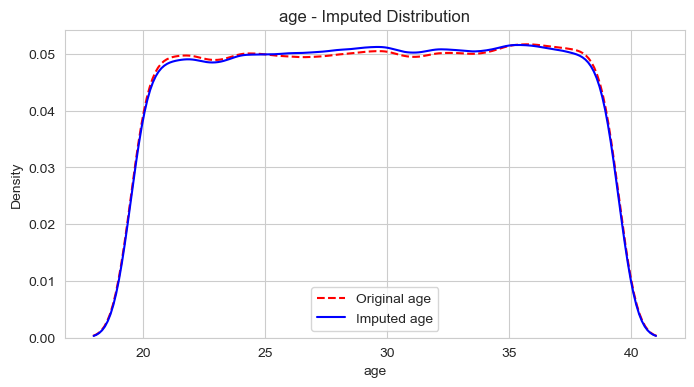

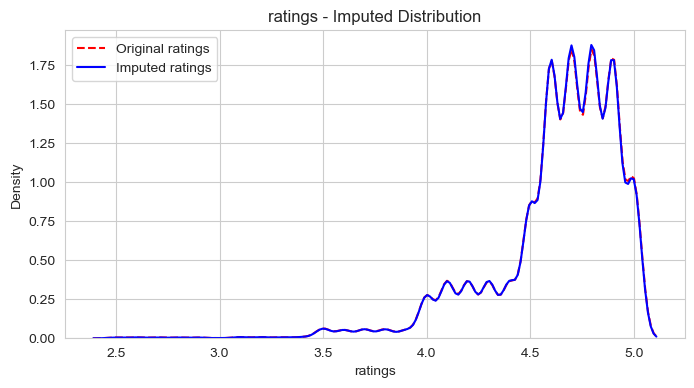

time_taken has no null values


<Figure size 800x400 with 0 Axes>

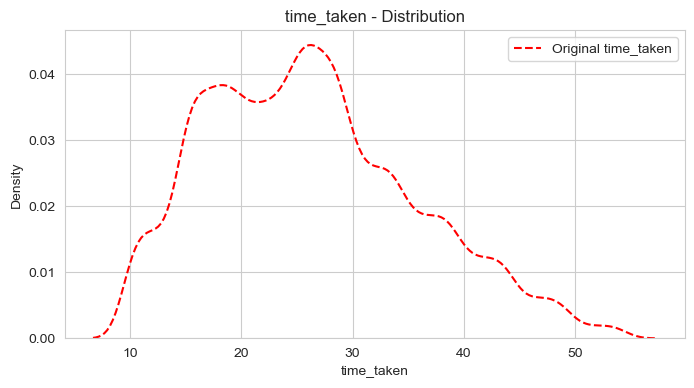

order_day has no null values


<Figure size 800x400 with 0 Axes>

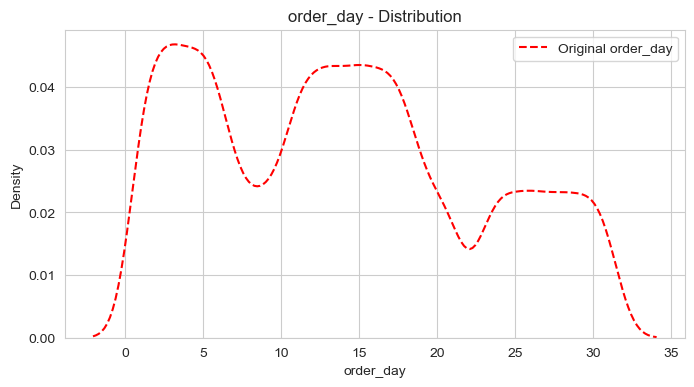

order_month has no null values


<Figure size 800x400 with 0 Axes>

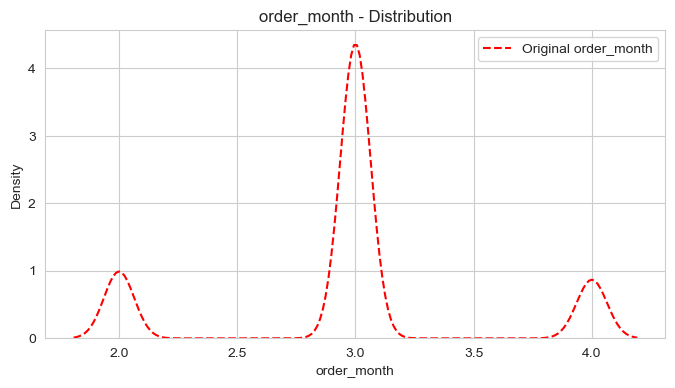

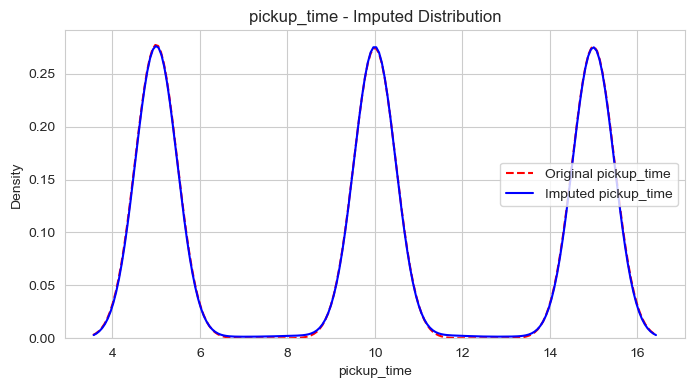

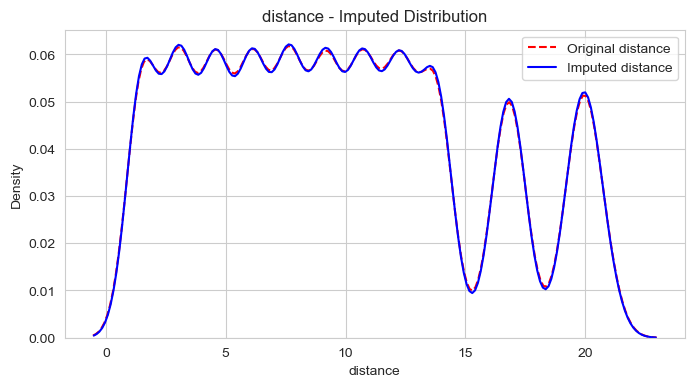

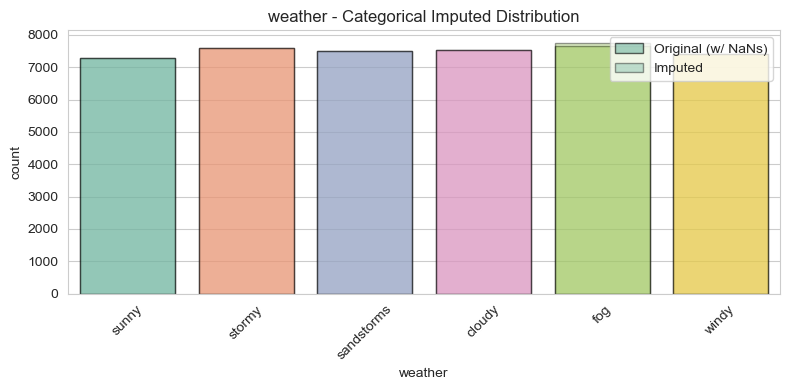

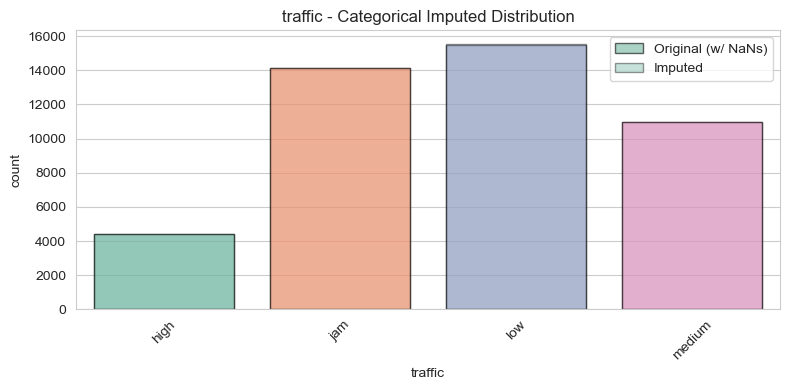

vehicle_condition has no null values


<Figure size 800x400 with 0 Axes>

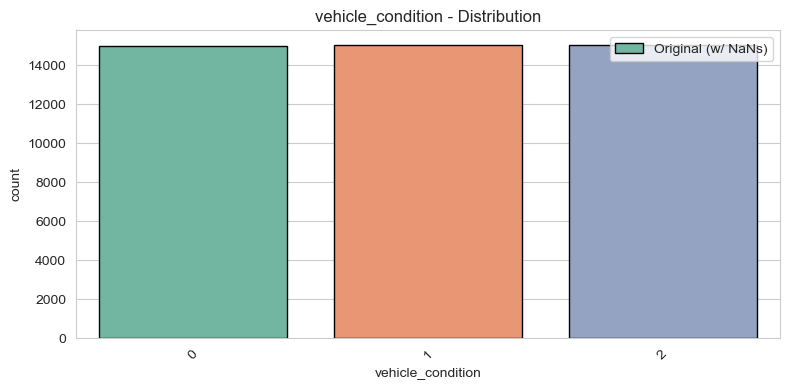

type_of_order has no null values


<Figure size 800x400 with 0 Axes>

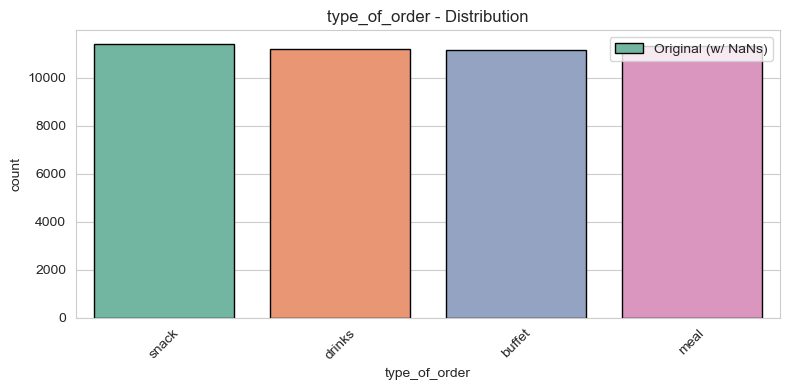

type_of_vehicle has no null values


<Figure size 800x400 with 0 Axes>

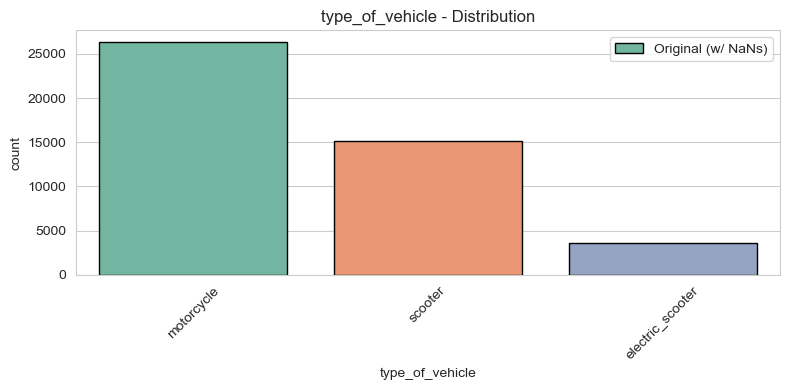

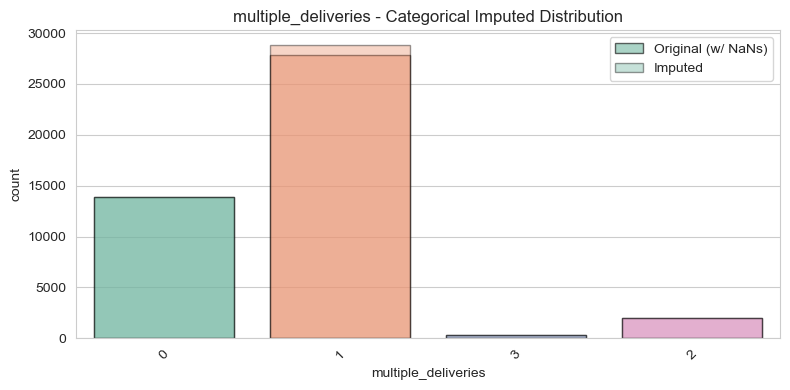

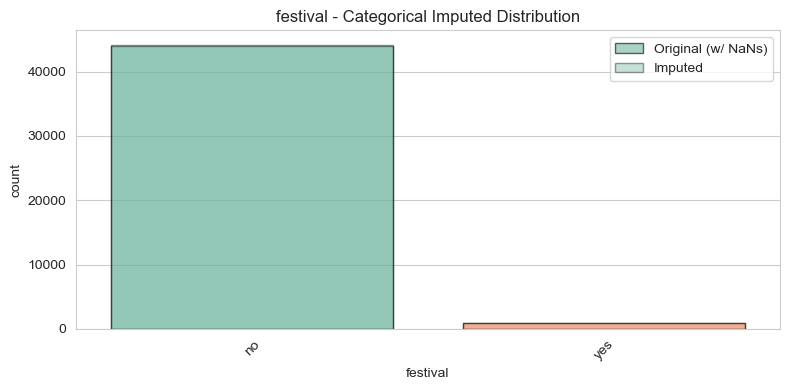

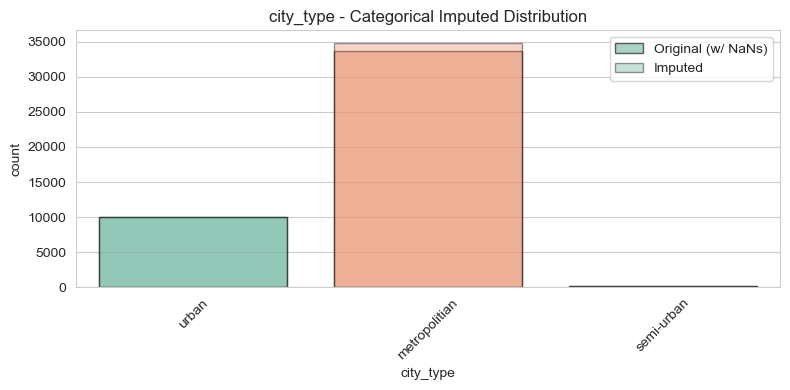

city_name has no null values


<Figure size 800x400 with 0 Axes>

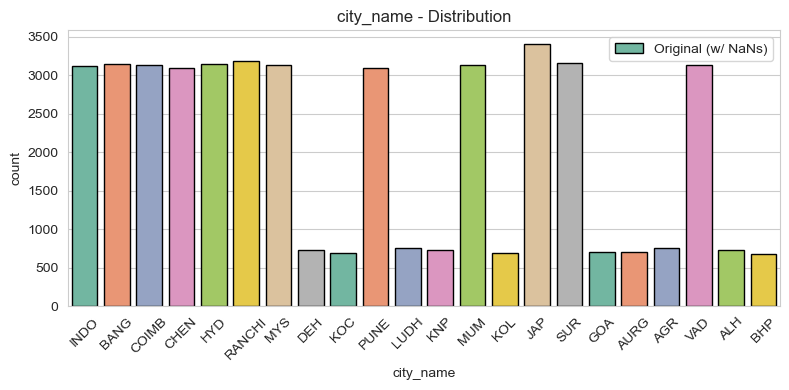

order_day_of_week has no null values


<Figure size 800x400 with 0 Axes>

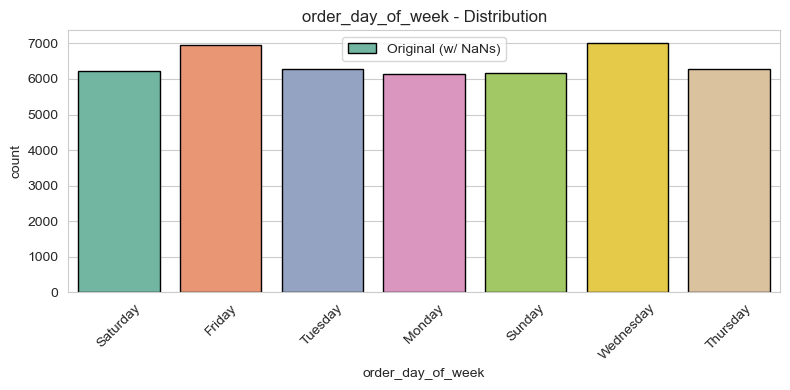

is_weekend has no null values


<Figure size 800x400 with 0 Axes>

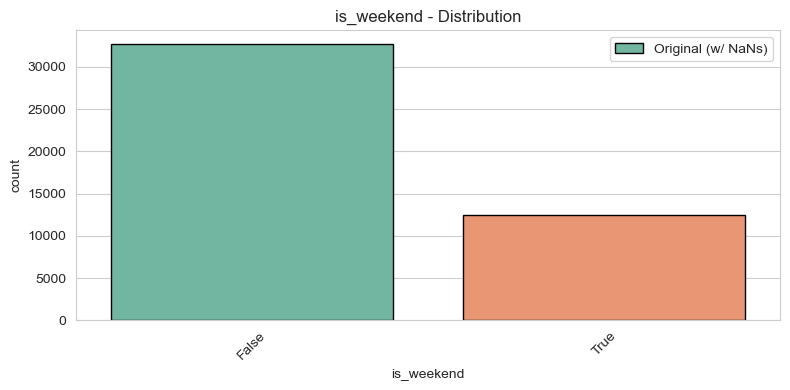

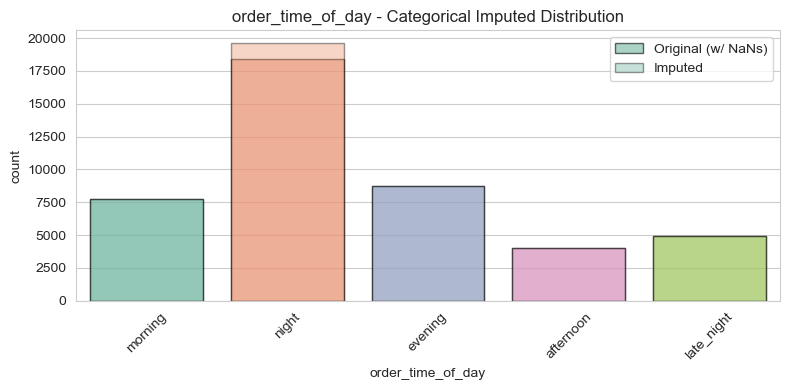


Total Imputation Time: 22.16 seconds


In [47]:
df_imputed = impute_combined(df_cleaned,knn_cols=['age','ratings','pickup_time'],
                                 random_cols=['distance'],
                                 mode_cols=['multiple_deliveries','weather','traffic','festival','city_type'
                                            ,'order_time_of_day']
                            )

In [48]:
df_imputed.isnull().sum()

age                    0
ratings                0
weather                0
traffic                0
vehicle_condition      0
type_of_order          0
type_of_vehicle        0
multiple_deliveries    0
festival               0
city_type              0
time_taken             0
city_name              0
order_day              0
order_month            0
order_day_of_week      0
is_weekend             0
pickup_time            0
order_time_of_day      0
distance               0
dtype: int64

In [49]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45073 entries, 0 to 45592
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  45073 non-null  float64
 1   ratings              45073 non-null  float64
 2   weather              45073 non-null  object 
 3   traffic              45073 non-null  object 
 4   vehicle_condition    45073 non-null  object 
 5   type_of_order        45073 non-null  object 
 6   type_of_vehicle      45073 non-null  object 
 7   multiple_deliveries  45073 non-null  object 
 8   festival             45073 non-null  object 
 9   city_type            45073 non-null  object 
 10  time_taken           45073 non-null  float64
 11  city_name            45073 non-null  object 
 12  order_day            45073 non-null  int64  
 13  order_month          45073 non-null  int64  
 14  order_day_of_week    45073 non-null  object 
 15  is_weekend           45073 non-null 

In [50]:
df1 = pd.read_csv('swiggy_cleaned_data.csv',  dtype={'is_weekend':'object'})
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45073 entries, 0 to 45072
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  43648 non-null  float64
 1   ratings              43594 non-null  float64
 2   weather              44977 non-null  object 
 3   traffic              44992 non-null  object 
 4   vehicle_condition    45073 non-null  int64  
 5   type_of_order        45073 non-null  object 
 6   type_of_vehicle      45073 non-null  object 
 7   multiple_deliveries  44089 non-null  float64
 8   festival             44848 non-null  object 
 9   city_type            43893 non-null  object 
 10  time_taken           45073 non-null  float64
 11  city_name            45073 non-null  object 
 12  order_day            45073 non-null  int64  
 13  order_month          45073 non-null  int64  
 14  order_day_of_week    45073 non-null  object 
 15  is_weekend           45073 non-null 

In [51]:
df1.head()

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,city_name,order_day,order_month,order_day_of_week,is_weekend,pickup_time,order_time_of_day,distance
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24.0,INDO,19,3,Saturday,True,15.0,morning,3.025149
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33.0,BANG,25,3,Friday,False,5.0,night,20.183530
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26.0,BANG,19,3,Saturday,True,15.0,morning,1.552758
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21.0,COIMB,5,4,Tuesday,False,10.0,evening,7.790401
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30.0,CHEN,26,3,Saturday,True,15.0,afternoon,6.210138


In [52]:
df2 = pd.read_csv('swiggy_imputed_data.csv',  dtype={'is_weekend':'object'})
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45073 entries, 0 to 45072
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  45073 non-null  float64
 1   ratings              45073 non-null  float64
 2   weather              45073 non-null  object 
 3   traffic              45073 non-null  object 
 4   vehicle_condition    45073 non-null  int64  
 5   type_of_order        45073 non-null  object 
 6   type_of_vehicle      45073 non-null  object 
 7   multiple_deliveries  45073 non-null  int64  
 8   festival             45073 non-null  object 
 9   city_type            45073 non-null  object 
 10  time_taken           45073 non-null  float64
 11  city_name            45073 non-null  object 
 12  order_day            45073 non-null  int64  
 13  order_month          45073 non-null  int64  
 14  order_day_of_week    45073 non-null  object 
 15  is_weekend           45073 non-null 

In [53]:
df2.head()

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,city_name,order_day,order_month,order_day_of_week,is_weekend,pickup_time,order_time_of_day,distance
0,37.0,4.9,sunny,high,2,snack,motorcycle,0,no,urban,24.0,INDO,19,3,Saturday,True,15.0,morning,3.03
1,34.0,4.5,stormy,jam,2,snack,scooter,1,no,metropolitian,33.0,BANG,25,3,Friday,False,5.0,night,20.18
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1,no,urban,26.0,BANG,19,3,Saturday,True,15.0,morning,1.55
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1,no,metropolitian,21.0,COIMB,5,4,Tuesday,False,10.0,evening,7.79
4,32.0,4.6,cloudy,high,1,snack,scooter,1,no,metropolitian,30.0,CHEN,26,3,Saturday,True,15.0,afternoon,6.21


In [54]:
df_cleaned.shape

(45073, 19)

In [55]:
df_imputed.shape

(45073, 19)

In [33]:
from sklearn.preprocessing import OrdinalEncoder

custom_orders = {
    'weather': ['Fog', 'Stormy', 'Sandstorms', 'Windy', 'Cloudy', 'Sunny'],
    'traffic': ['Low', 'Medium', 'High', 'Jam'],
    'type_of_order': ['Drinks', 'Snack', 'Meal', 'Buffet'],
    'type_of_vehicle': ['bicycle', 'electric_scooter', 'scooter', 'motorcycle'],
    'city_type': ['Semi-Urban', 'Urban', 'Metropolitian'],
    'day_of_week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    'order_time_of_day': ['late_night', 'morning', 'afternoon', 'evening', 'night']
}


def encode_with_sklearn_ordinal(df, custom_orders):
    df_encoded = df.copy()
    
    for col, order in custom_orders.items():
        encoder = OrdinalEncoder(categories=[order], handle_unknown='use_encoded_value', unknown_value=-1)
        df_encoded[col] = encoder.fit_transform(df_encoded[[col]])  
        #df_encoded[[col]]: Ensures the column is passed as 2D (which OrdinalEncoder requires).

    return df_encoded